# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 5.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("AAPL", start="1990-01-01", end="2022-02-25")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.264482,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.266257,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.267145,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.268033,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.269808,101572800
...,...,...,...,...,...,...
2022-02-17,171.029999,171.910004,168.470001,168.880005,167.863144,69589300
2022-02-18,169.820007,170.539993,166.190002,167.300003,166.292648,82772700
2022-02-22,164.979996,166.690002,162.149994,164.320007,163.330597,91162800


In [4]:
scaled_data

array([[ 0.00671094],
       [ 0.00333617],
       [ 0.00332206],
       ...,
       [-0.01781229],
       [-0.02586417],
       [ 0.01668019]])

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [5]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > 0:
      y_train.append(1)
    else:
      y_train.append(0)
#    y_train.append(train_data[i, 0])



x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [17]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(30, return_sequences=False))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=10, epochs=3)

Epoch 1/3
648/648 [==============================] - 16s 12ms/step - loss: 0.6934 - accuracy: 0.4907
Epoch 2/3
648/648 [==============================] - 10s 15ms/step - loss: 0.6933 - accuracy: 0.4931
Epoch 3/3
648/648 [==============================] - 13s 21ms/step - loss: 0.6933 - accuracy: 0.4982


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [18]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = []
y_test_origin = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    if y_test_origin[i-input_size] > 0:
      y_test.append(1)
    else:
      y_test.append(0)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(len(x_test), len(y_test))

1620 1620


In [19]:
predictions_test = model.predict(x_test)

51/51 [==============================] - 1s 4ms/step


In [20]:
predictions_train = model.predict(x_train)

203/203 [==============================] - 1s 4ms/step


In [21]:
len(predictions_train)

6475

In [22]:
import matplotlib.pyplot as plt

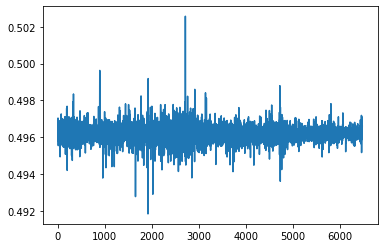

In [23]:
plt.plot(predictions_train)

In [33]:
# Test insample Accurracy
from sklearn.metrics import accuracy_score
test_is = accuracy_score(
  y_train,
  np.round(predictions_train)
  )
test_is

0.5023938223938224

In [34]:
# Test insample random walk assumption Accuracy
y_train_rw = np.zeros_like(y_train)
y_train_rw[1:] = y_train[:-1]
test_is_rw = accuracy_score(
  y_train,
  y_train_rw
  )
test_is_rw

0.49498069498069497

In [35]:
# Test out of sample Accuracy
test_os = accuracy_score(
  y_test,
  np.round(predictions_test)
  )
test_os

0.4679012345679012

In [36]:
# Test out of sample random walk assumption Accuracy
y_test_rw = np.zeros_like(y_test)
y_test_rw[1:] = y_test[:-1]
test_os_rw = accuracy_score(
  y_test,
  y_test_rw
  )
test_os_rw

0.4858024691358025

Text(0.5, 1.0, 'Accuracy Score')

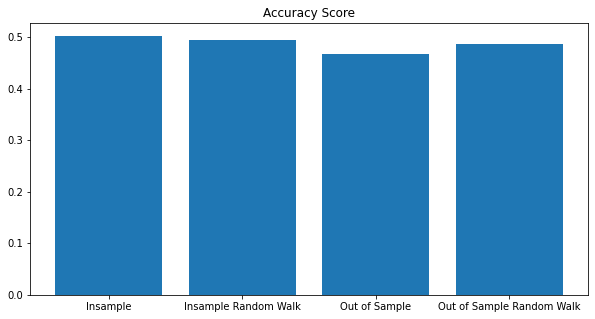

In [41]:
plt.figure(figsize = (10,5))
plt.bar(['Insample','Insample Random Walk','Out of Sample','Out of Sample Random Walk'], [test_is,test_is_rw,test_os,test_os_rw])
plt.title('Accuracy Score')

# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

- The accuracy score for insample data is 0.5024 and the accuracy score for insample random walk assumption is 0.4950, so the model performs slightly better than random walk guessing. 

- The accuracy score for out of sample data is 0.4679 and the accuracy score for out of sample random walk assumption is 0.4858, so the model performs worse than random walk guessing. It seems that the model performs badly on the dataset. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define datasplit function
def datasplit(time_lags):
# Split train data
    input_size = time_lags

    # Split data into training and test sets
    training_data_len = int(len(scaled_data) * 0.8)
    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []    
    for i in range(input_size, len(train_data)):
        x_train.append(train_data[i-input_size:i, 0])
        if train_data[i, 0] > 0:
          y_train.append(1)
        else:
          y_train.append(0)
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Split test data
    test_data = scaled_data[training_data_len - input_size:, :]
    x_test = []
    y_test = []
    y_test_origin = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
    for i in range(input_size, len(test_data)):
        x_test.append(test_data[i-input_size:i, 0])
        if y_test_origin[i-input_size] > 0:
          y_test.append(1)
        else:
          y_test.append(0)
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return x_train, y_train

#x_train, y_train = datasplit(5)

# Define the Keras model
###Edit here to create your optimizer
def create_model(time_lags):
# Create model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_lags, 1)))
    model.add(LSTM(30, return_sequences=False))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return(model)


# Wrap the Keras model in a scikit-learn compatible estimator
# model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
#param_grid = {'batch_size': [10, 20, 100],
#              'epochs': [10, 100],
#              'neurons':[5,10,20]}

param_grid = {'time_lags': [5, 10, 20]}
# Perform the grid search over the hyperparameters


for tl in param_grid['time_lags']:
  x_train, y_train = datasplit(tl)
  model = KerasRegressor(build_fn=create_model, verbose=0)
  grid = GridSearchCV(estimator=model, param_grid = {'time_lags': [tl]}, n_jobs=-1, cv=3)
  grid_result = grid.fit(x_train, y_train, batch_size=10, epochs=3)

  # Print the results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-208-f2e32c1ad622>:67: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.695274 using {'time_lags': 5}
Best: -0.695274 using {'time_lags': 10}
Best: -0.694354 using {'time_lags': 20}


So using 20 as the time lag generates the best result.